# STL Decomposition

In [40]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv("C:/Users/simon.senegas/Documents/Perso/works/solar_prediction/data/Dataset-SolarTechLab.csv", sep=";")
print(df.shape, df.isna().sum())

(525601, 7) Time             0
PV_Power    326871
T_air         4854
G_h           4854
G_tilt        4854
W_s           4854
W_d           4854
dtype: int64


NaN on PV Power seems to be missing measure, specifically when sun radiation is 0. Observe this

<Axes: xlabel='G_h', ylabel='Count'>

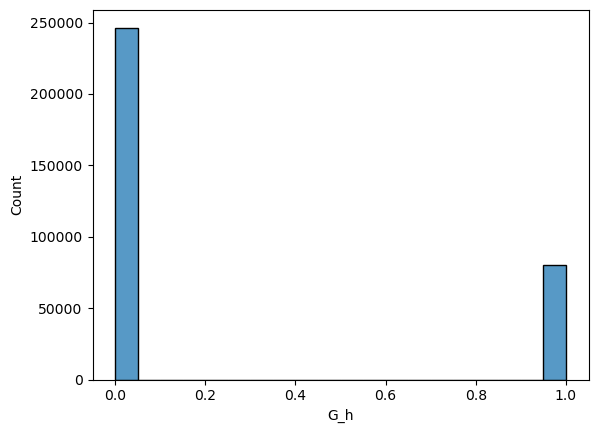

In [42]:
nan_values = df.loc[df["PV_Power"].isna()]
sns.histplot(nan_values["G_h"]>0)

Nous voyons que les seules valeurs de $G_h$ possibles lorsque la production sont 0 et 1, synonyme d'un ensoleillement nul. NaN = 0.

In [43]:
df["PV_Power"] = df["PV_Power"].fillna(0)
df = df[~df.isna()]

In [44]:
df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time")

C:\Users\simon.senegas\AppData\Local\Temp\ipykernel_11332\3170157220.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(df["Time"])


In [45]:
df.head()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
Time,,,,,,
2017-01-01 00:00:00,0.0,0.74,0.0,0.0,0.30,296.4
2017-01-01 00:01:00,0.0,0.67,0.0,0.0,0.47,269.2
2017-01-01 00:02:00,0.0,0.57,0.0,0.0,0.84,265.3
2017-01-01 00:03:00,0.0,0.53,0.0,0.0,0.63,275.4
2017-01-01 00:04:00,0.0,0.53,0.0,0.0,0.58,265.3


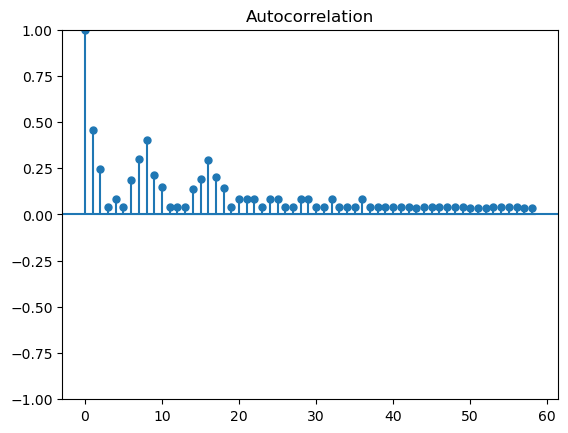

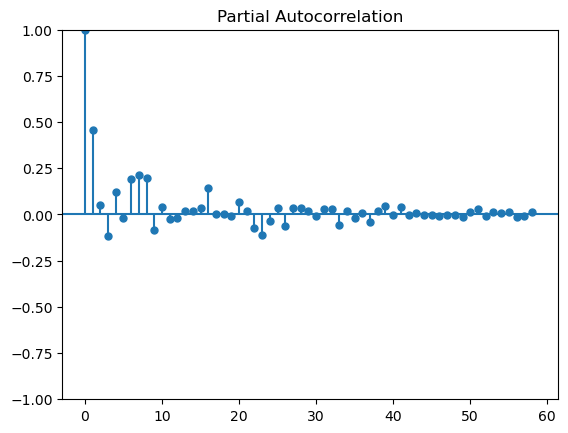

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["PV_Power"])
plot_pacf(df["PV_Power"])
plt.show()

In [47]:
df

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
Time,,,,,,
2017-01-01 00:00:00,0.0,0.74,0.0,0.0,0.30,296.4
2017-01-01 00:01:00,0.0,0.67,0.0,0.0,0.47,269.2
2017-01-01 00:02:00,0.0,0.57,0.0,0.0,0.84,265.3
2017-01-01 00:03:00,0.0,0.53,0.0,0.0,0.63,275.4
2017-01-01 00:04:00,0.0,0.53,0.0,0.0,0.58,265.3
...,...,...,...,...,...,...
2017-12-31 23:56:00,0.0,2.91,0.0,0.0,0.41,68.2
2017-12-31 23:57:00,0.0,2.85,0.0,0.0,1.01,42.8
2017-12-31 23:58:00,0.0,2.83,0.0,0.0,1.22,46.6


In [48]:
df_analysis = df.loc["2017-07"]

<Axes: xlabel='Time', ylabel='PV_Power'>

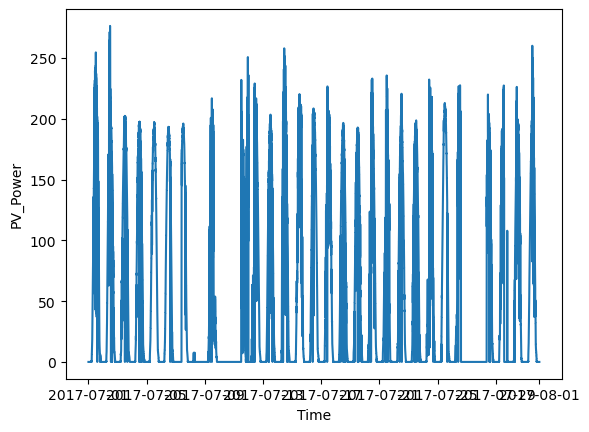

In [49]:
sns.lineplot(df_analysis["PV_Power"])

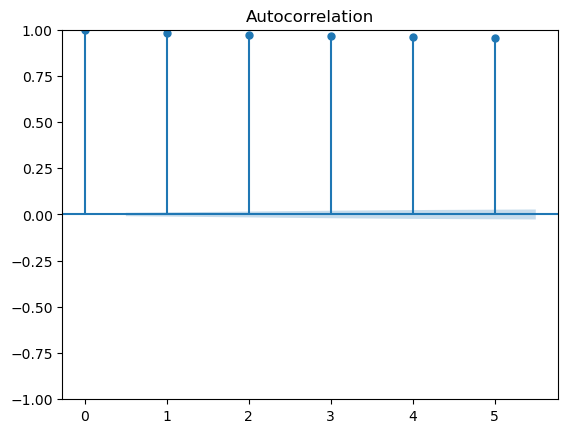

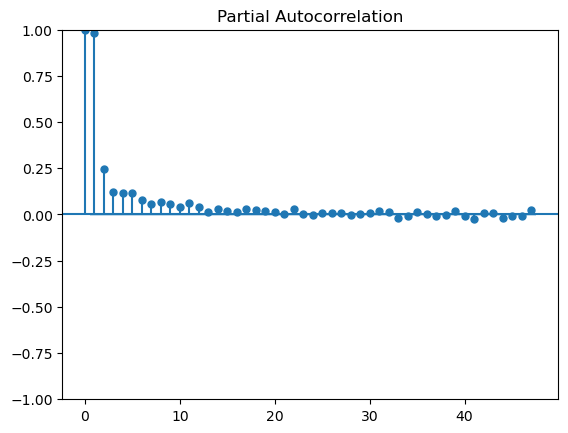

In [56]:
plot_acf(df_analysis["PV_Power"], lags=5)
plot_pacf(df_analysis["PV_Power"])
plt.show()

- ACF : L'autocorrélation semble être décroissante au cours du temps, synonyme que p > 0 (composante AR forte, ce qui est intuitif avec le comportement physique d'un panneau solaire)
- PACF : L'autocorrélation partielle décroit très fortement après le deuxième pic, synonyme d'un q = 0 (pas de composante MA)

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_analysis["PV_Power"], model="additive", period=1440)

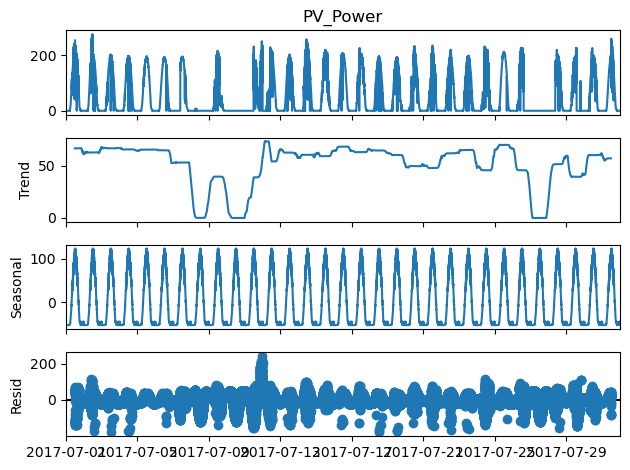

In [52]:
result.plot()
plt.show()

Sur un mois, nous n'observons pas de trend. Le comportement des panneaux solaires est plutôt constant. Nous observons par contre une forte saisonnalité (que l'on pressent être journalière). Nous pouvons par un test de adfuller regarder la stationnarité de la série.

In [53]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_analysis["PV_Power"])

(np.float64(-6.065773685806271),
 np.float64(1.1828188221690535e-07),
 55,
 44584,
 {'1%': np.float64(-3.430496682140291),
  '5%': np.float64(-2.861604830320002),
  '10%': np.float64(-2.5668045070654197)},
 np.float64(356748.46499335463))

La valeur est fortement négative est inférieure à la valeur de 1%, avec une p-value extrêmement faible. On peut donc rejeter l'hypothèse nulle et prendre la série comme stationnaire.

### Analyse spectrale pour déterminer la saisonnalité : Transformée de Fourier

In [ ]:
from scipy.fft import fft
yf = fft(df_analysis["PV_Power"])